# Song lyrics exploration - Part 2: Lexical diversity

In [4]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)
from nltk.corpus import words as nltk_words

from nlp import tokenize

# Loading and pre-processing data

In [5]:
def get_genres(data):
    columns = [col for col in data.columns if 'genre_' in col]
    genres = [re.sub(r"^genre\_", "", col) for col in columns]
    return genres, columns


def get_bands(data):
    genres, genre_cols = get_genres(data)
    # Combine songs from same band
    band_genres = data.groupby('band_name')[genre_cols].max()
    band_lyrics = data.groupby('band_name').song_darklyrics.sum()
    bands = pd.concat((band_genres, band_lyrics), axis=1)
    bands.columns = genres + ['lyrics']
    bands['words'] = bands.lyrics.apply(tokenize)
    return bands


def get_songs(data):
    genres, genre_cols = get_genres(data)
    songs = data[['band_name', 'song_name'] + genre_cols + ['song_darklyrics']].copy()
    songs.columns = ['band_name', 'song_name'] + genres + ['lyrics']
    songs['words'] = songs.lyrics.apply(tokenize)
    return songs

In [6]:
df = pd.read_csv('songs-10pct.csv')
df_bands = get_bands(df)
df_songs = get_songs(df)

# Lexical diversity measures

A few lexical diversity measures are going to be used to compare bands and genres. 

$$
\begin{split}
&LD_{TTR} &= \frac{V}{N} &\hspace{1cm} (\textrm{type-token ratio})\\
&LD_{rootTTR} &= \frac{V}{\sqrt{N}} &\hspace{1cm} (\textrm{root type-token ratio})\\
&LD_{logTTR} &= \frac{\log{V}}{\log{N}} &\hspace{1cm} (\textrm{logarithmic type-token ratio})\\
\end{split}
$$

Measure of Textual Lexical Diversity: [McCarthy and Jarvis (2010)](https://doi.org/10.3758/BRM.42.2.381)

In [7]:
def MTLD_forward(words, threshold, verbose=False):
    def TTR(x):
        return len(set(x)) / len(x)
    factor = 0
    segment = []
    i = 0
    while i < len(words):
        segment.append(words[i])
        segTTR = TTR(segment)
        if verbose:
            print(i, segment, factor, segTTR)
        if segTTR <= threshold:
            segment = []
            factor += 1
        i += 1
    if len(segment) > 0:
        factor += (1.0 - segTTR) / (1.0 - threshold)
        if verbose:
            print(segment, factor)
    factor = max(1.0, factor)
    mtld = len(words) / factor
    return mtld


def MTLD(words, threshold=0.720, verbose=False):
    if len(words) == 0:
        return 0.0
    forward = MTLD_forward(words, threshold, verbose=verbose)
    reverse = MTLD_forward(words[::-1], threshold, verbose=verbose)
    return 0.5 * (forward + reverse)

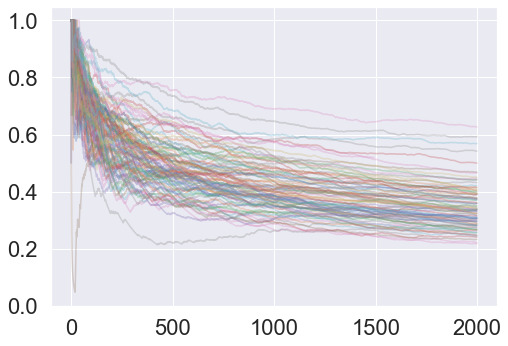

In [8]:
def cumulative_TTR(words):
    def TTR(x):
        return len(set(x)) / len(x)
    out = [TTR(words[: i + 1]) for i in range(len(words))]
    return out

for i in range(0, 1000, 10):
    plt.plot(cumulative_TTR(df_bands.iloc[i].words[:2000]), alpha=0.3)
plt.show()

In [9]:
for band in df_bands.index:
    try:
        mtld = MTLD(df_bands.loc[band].words)
    except ZeroDivisionError:
        print(band)

In [10]:
for song in df_songs.index:
    try:
        mtld = MTLD(df_songs.loc[song].words)
    except ZeroDivisionError:
        print(song)

In [11]:
df_bands.loc['Krieg'].words

['how',
 'can',
 'you',
 'say',
 'that',
 "i'm",
 'not',
 'innocent',
 'withering',
 'in',
 'self-inflicted',
 'disease',
 'dense',
 'as',
 'the',
 'fog',
 'mind',
 'eye',
 'visions',
 'of',
 'failing',
 'geists',
 'faltering',
 'inside',
 'a',
 'tomb',
 'of',
 'pills',
 'skin',
 'cavern',
 'burden',
 'of',
 'future',
 'miscarriage',
 'unnatural',
 'features',
 'illuminated',
 'a',
 'flawed',
 'and',
 'ill-conceived',
 'unknown',
 'creatures',
 'this',
 'world',
 'is',
 'an',
 'abortion',
 'where',
 'all',
 'paths',
 'lead',
 'to',
 'god']

In [12]:
MTLD(df_bands.loc['Krieg'].words, threshold=0.99, verbose=True)

0 ['how'] 0 1.0
1 ['how', 'can'] 0 1.0
2 ['how', 'can', 'you'] 0 1.0
3 ['how', 'can', 'you', 'say'] 0 1.0
4 ['how', 'can', 'you', 'say', 'that'] 0 1.0
5 ['how', 'can', 'you', 'say', 'that', "i'm"] 0 1.0
6 ['how', 'can', 'you', 'say', 'that', "i'm", 'not'] 0 1.0
7 ['how', 'can', 'you', 'say', 'that', "i'm", 'not', 'innocent'] 0 1.0
8 ['how', 'can', 'you', 'say', 'that', "i'm", 'not', 'innocent', 'withering'] 0 1.0
9 ['how', 'can', 'you', 'say', 'that', "i'm", 'not', 'innocent', 'withering', 'in'] 0 1.0
10 ['how', 'can', 'you', 'say', 'that', "i'm", 'not', 'innocent', 'withering', 'in', 'self-inflicted'] 0 1.0
11 ['how', 'can', 'you', 'say', 'that', "i'm", 'not', 'innocent', 'withering', 'in', 'self-inflicted', 'disease'] 0 1.0
12 ['how', 'can', 'you', 'say', 'that', "i'm", 'not', 'innocent', 'withering', 'in', 'self-inflicted', 'disease', 'dense'] 0 1.0
13 ['how', 'can', 'you', 'say', 'that', "i'm", 'not', 'innocent', 'withering', 'in', 'self-inflicted', 'disease', 'dense', 'as'] 0 1.0


54.0

In [13]:
def get_lexical_diversity(data):
    N = data.words.apply(len)
    V = data.words.apply(lambda x: len(set(x)))
    data['N'] = N
    data['V'] = V
    data['TTR'] = V / N
    data['rootTTR'] = V / np.sqrt(N)
    data['logTTR'] = np.log(V) / np.log(N)
    data['mtld'] = data.words.apply(MTLD, threshold=0.5)
    data['logmtld'] = np.log(data['mtld'])
    return data[data.N > 0]

In [14]:
df_bands = get_lexical_diversity(df_bands)
df_songs = get_lexical_diversity(df_songs)

C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Histograms

In [15]:
def plot_histograms(data):
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle("Lexical diversity of heavy metal artists", fontsize=30)
    axes = axes.flatten()

    ax = axes[0]
    logNmin, logNmax = np.log10(data.N.min()), np.log10(data.N.max())
    logbins = np.logspace(logNmin, logNmax, 20)
    data.N.hist(bins=logbins, edgecolor='k', ax=ax)
    ax.set_xscale('log')
    ax.set_title("Vocabulary sizes")
    ax.set_xlabel("N (tokens)")
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

    ax = axes[1]
    data.TTR.hist(bins=20, edgecolor='k', ax=ax)
    ax.set_title("Type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{TTR} = V/N}$")

    ax = axes[2]
    data.rootTTR.hist(bins=20, edgecolor='k', ax=ax)
    ax.set_title("Root type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{rootTTR}} = \sqrt{V/N}$")

    ax = axes[3]
    data.logTTR.hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("Logarithmic type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{logTTR}} = \log V / \log N$")

    ax = axes[4]
    data.logmtld[data.logmtld > -np.inf].hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("Measure of Textual Lexical Diversity")
    ax.set_xlabel("$\log(\mathrm{MTLD})$")

    ax = axes[5]
    ax.axis('off')

    for ax in axes:
        ax.set_ylabel("Artists", rotation=0, labelpad=40)
        ax.grid(None)
        ax.grid(axis='y', color='k')

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return

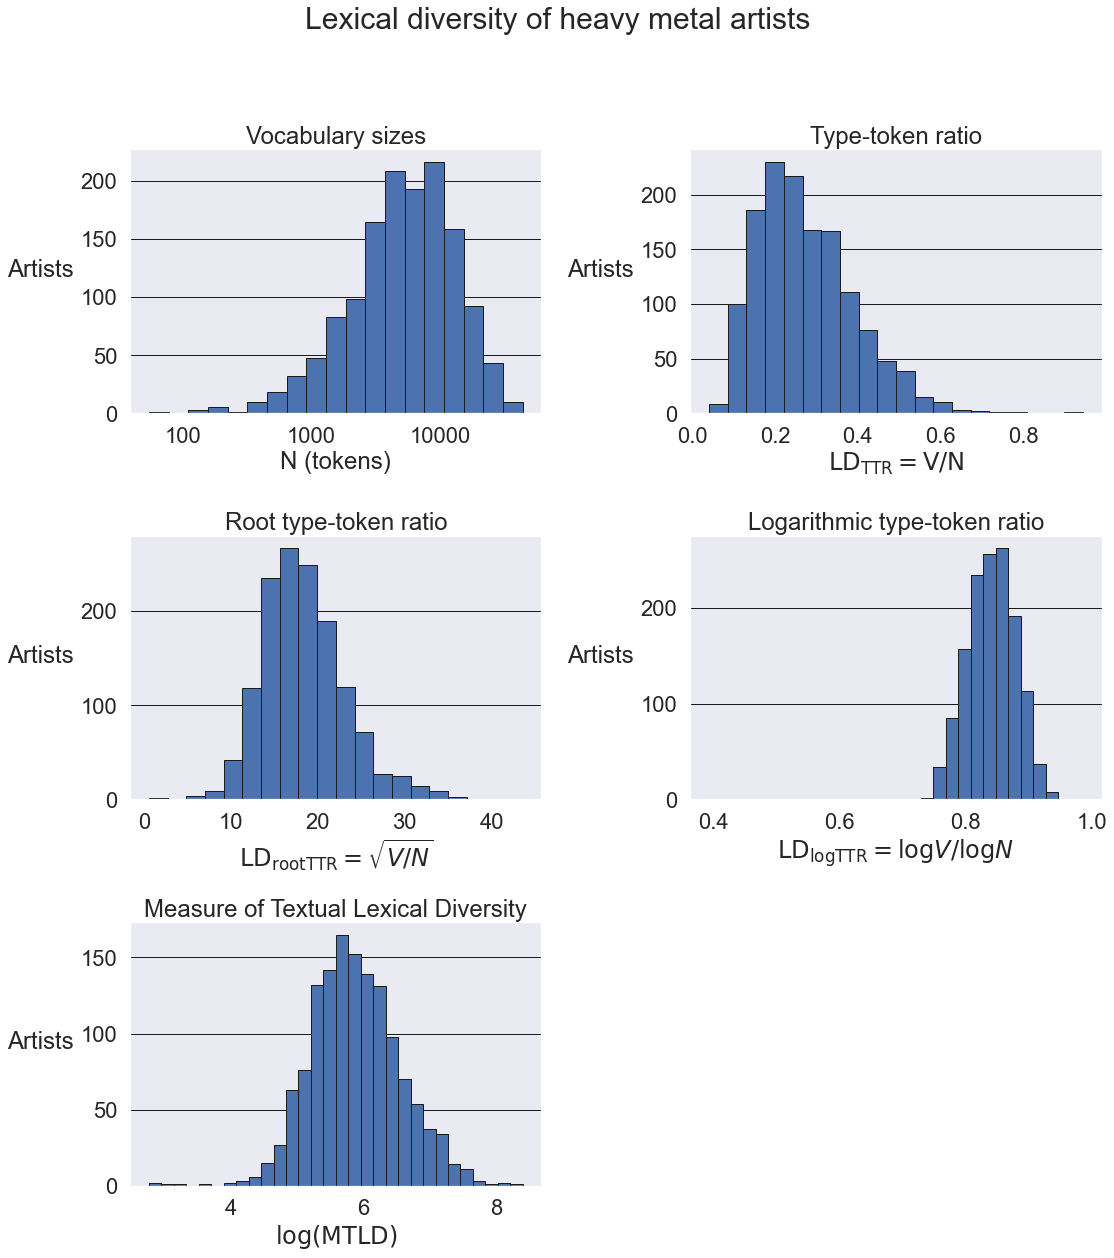

In [16]:
plot_histograms(df_bands)

# Violin plots

In [17]:
def plot_violinplots(data, figsize=(16, 18)):

    def violinplot(col, ax):
        violindata = []
        labels = data.columns[:list(data.columns).index('lyrics')]
        for label in labels:
            values = data[data[label] == 1][col]
            values = values[(values > -np.inf) & (values < np.inf)]
            violindata.append((label, values))
        violindata.sort(key=lambda x: -x[1].median())
        plot_labels, plot_data = zip(*violindata)
        sns.violinplot(data=plot_data, cut=0, orient='h', ax=ax, color='c')
        ax.set_yticklabels(plot_labels)
        return

    fig, axes = plt.subplots(3, 2, figsize=figsize)
    fig.suptitle("Lexical diversity of artists by genre", fontsize=30)
    axes = axes.flatten()

    ax = axes[0]
    violinplot('N', ax)
    ax.set_title("Word counts")
    ax.set_xlabel("N (tokens)")

    ax = axes[1]
    violinplot('V', ax)
    ax.set_title("Unique word counts")
    ax.set_xlabel("V (types)")

    ax = axes[2]
    violinplot('TTR', ax)
    ax.set_title("Type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{TTR}}$")

    ax = axes[3]
    violinplot('logTTR', ax)
    ax.set_title("Logarithmic type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{logTTR}}$")

    ax = axes[4]
    violinplot('logmtld', ax)
    ax.set_title("Measure of Textual Lexical Diversity")
    ax.set_xlabel("$\log(\mathrm{MTLD})$")

    ax = axes[5]
    ax.axis('off')

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return

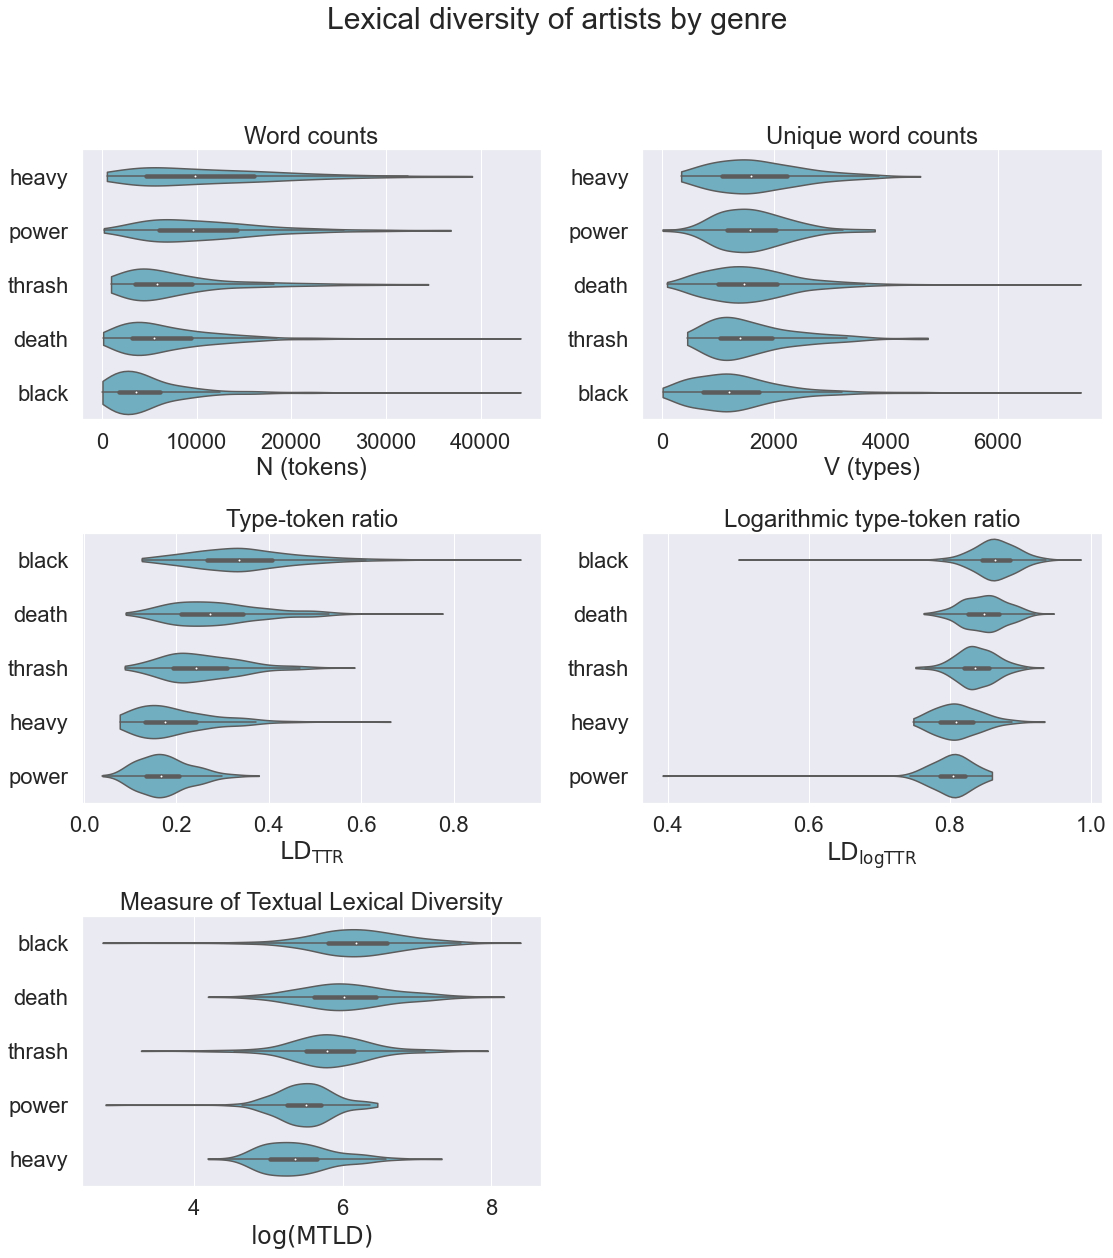

In [18]:
plot_violinplots(df_bands, figsize=(16, 18))

In [19]:
df_bands.sort_values('mtld', ascending=False)[:20]

,black,death,heavy,power,thrash,lyrics,words,N,V,TTR,rootTTR,logTTR,mtld,logmtld
band_name,,,,,,,,,,,,,,
Horna,1,0,0,0,0,"\n...Vanhoihin synkkiin ajatuksiin.\n\n""Ash na...","[vanhoihin, synkkiin, ajatuksiin, ash, nazg, d...",4416,2285,0.517437,34.385209,0.921498,4416.000000,8.392990
Hail of Bullets,0,1,0,0,0,\nHear the engines roaring\nHear the grinding ...,"[hear, the, engines, roaring, hear, the, grind...",3531,1849,0.523648,31.116307,0.920809,3531.000000,8.169336
Malignancy,0,1,0,0,0,\nFrom vaginal sores seep fetid secretions \r\...,"[from, vaginal, sores, seep, fetid, secretions...",5530,2094,0.378662,28.158798,0.887315,3110.126557,8.042419
Demolition Hammer,0,0,0,0,1,\nProgressive evolution\nSpawns a hybrid breed...,"[progressive, evolution, spawns, a, hybrid, br...",2844,1664,0.585091,31.202438,0.932605,2844.000000,7.952967
Lugubrum,1,0,0,0,0,\nBen zi bena\nCounting roots and worms\nThe s...,"[ben, zi, bena, counting, roots, and, worms, t...",2449,1496,0.610862,30.229934,0.936837,2449.000000,7.803435
Abnormality,0,1,0,0,0,\nInnocence. Intervals I cannot recall\r\nElim...,"[innocence, intervals, i, cannot, recall, elim...",2443,1235,0.505526,24.986488,0.912555,2443.000000,7.800982
Brutality,0,1,0,0,0,\n\n\n\nTomb of desecration\nSadistic land ete...,"[tomb, of, desecration, sadistic, land, eterna...",3523,1659,0.470905,27.950531,0.907788,2113.482834,7.656092
Kauan,0,0,0,0,0,"\nHiljaa tyhjään ohjaten,\nLämmön läpi kämment...","[hiljaa, tyhj, n, ohjaten, l, mm, n, l, pi, k,...",2072,1167,0.563224,25.637518,0.924822,2072.000000,7.636270
Wormed,0,1,0,0,0,\nExpulsion\r\nAbstract vector space\r\nElectr...,"[expulsion, abstract, vector, space, electrons...",2003,1099,0.548677,24.555977,0.921045,2003.000000,7.602401


The song with the highest MTLD is a 6-minute track by the Hungarian folk metal band Dalriada, "Zách Klára". Its MTLD is actually being inflated by its not being in English; the many accent marks in the [Hungarian lyrics](http://www.darklyrics.com/lyrics/dalriada/aranyalbum.html#1) result in some issues with parsing and therefore counting words, yielding a much higher MTLD than would probably be seen if it were directly translated into English.

Several of the highest MTLD scores come from Bal-Sagoth songs. These too have been inflated, in this case because [Bal-Sagoth's lyrics](http://www.darklyrics.com/lyrics/balsagoth/thechthonicchronicles.html#4) consist of entire chapters of prose not actually sung in the songs themselves.

Ulver's ["Stone Angels"](https://youtu.be/ND-0q-Ayd7c) may be the first legitimate claim to the throne. The lyrics are in English and are all heard in the song. However, they are spoken rather than sung, so although this is indeed the most lyrically diverse set of lyrics, it isn't the most diverse among sung lyrics.

That accolade may fall on Cradle of Filth's ["Beneath the Howling Stars"](https://youtu.be/bz54wJ2qh3M). The seven-and-a-half-minute epic delivers through screams and some spoken word the tale of the 16th-century Hungarian serial killer, Elizabeth Bathory.

In [20]:
df_songs.sort_values('mtld', ascending=False)[:20]

,band_name,song_name,black,death,heavy,power,thrash,lyrics,words,N,V,TTR,rootTTR,logTTR,mtld,logmtld
13134,Dalriada,Zách Klára,0,0,0,0,0,"\nRossz időket érünk,\nRossz csillagok járnak....","[rossz, id, ket, r, nk, rossz, csillagok, j, r...",944,485,0.513771,15.785405,0.902779,944.000000,6.850126
5826,Bal-Sagoth,The Obsidian Crown Unbound,1,0,0,0,0,"\n\n\nFrom Sage Daelun's ""Chronicles of Antedi...","[from, sage, daelun, chronicles, of, antediluv...",2391,993,0.415307,20.307640,0.887044,914.286940,6.818144
5825,Bal-Sagoth,Six Score and Ten Oblations to a Malefic Avatar,1,0,0,0,0,\n\n\n\nI have come into possession of a certa...,"[i, have, come, into, possession, of, a, certa...",839,452,0.538737,15.604773,0.908124,839.000000,6.732211
56670,Ulver,Stone Angels,1,0,0,0,0,"\n\n\nAngels go - we\nmerely stray, image of\n...","[angels, go, -, we, merely, stray, image, of, ...",769,418,0.543563,15.073466,0.908262,769.000000,6.645091
5797,Bal-Sagoth,Summoning the Guardians of the Astral Gate,1,0,0,0,0,\nIt is written in the ancient legends... that...,"[it, is, written, in, the, ancient, legends, t...",759,404,0.532279,14.664271,0.904918,759.000000,6.632002
13146,Dalriada,Szondi két apródja (2. rész),0,0,0,0,0,"\nHadd zúgjon az álgyu! pogány Ali mond,\nPatt...","[hadd, z, gjon, az, lgyu, pog, ny, ali, mond, ...",754,437,0.579576,15.914601,0.917671,754.000000,6.625392
5791,Bal-Sagoth,To Dethrone the Witch-Queen of Mytos K'unn (Th...,1,0,0,0,0,"\n\nThe vast armies of Mytos K'unn, marshalle...","[the, vast, armies, of, mytos, k'unn, marshall...",1413,621,0.439490,16.520399,0.886656,741.826206,6.609115
5830,Bal-Sagoth,Unfettering the Hoary Sentinels of Karnak,1,0,0,0,0,\n\nWhen Blackthorne returns from his expediti...,"[when, blackthorne, returns, from, his, expedi...",1338,623,0.465620,17.031778,0.893820,722.582523,6.582832
12000,Cradle of Filth,Beneath the Howling Stars,1,1,0,0,0,\nMidwinter wrongs the rites of Spring\nHer sp...,"[midwinter, wrongs, the, rites, of, spring, he...",706,426,0.603399,16.032721,0.922987,706.000000,6.559615
5806,Bal-Sagoth,Blood Slakes the Sand at the Circus Maximus,1,0,0,0,0,\n\n\n\n\n Hearken! The Ninth Legion has been ...,"[hearken, the, ninth, legion, has, been, put, ...",1280,586,0.457813,16.379198,0.890798,701.022680,6.552540


In [21]:
df_songs[(df_songs['band_name'] != 'Bal-Sagoth') & (df_songs['band_name'] != 'Dalriada')].sort_values('mtld', ascending=False)[:20]

,band_name,song_name,black,death,heavy,power,thrash,lyrics,words,N,V,TTR,rootTTR,logTTR,mtld,logmtld
56670,Ulver,Stone Angels,1,0,0,0,0,"\n\n\nAngels go - we\nmerely stray, image of\n...","[angels, go, -, we, merely, stray, image, of, ...",769,418,0.543563,15.073466,0.908262,769.000000,6.645091
12000,Cradle of Filth,Beneath the Howling Stars,1,1,0,0,0,\nMidwinter wrongs the rites of Spring\nHer sp...,"[midwinter, wrongs, the, rites, of, spring, he...",706,426,0.603399,16.032721,0.922987,706.000000,6.559615
35841,Moonsorrow,Huuto,1,0,0,0,0,\nSilmänkantamattomiin jää silmät sokaisee | V...,"[silm, nkantamattomiin, j, silm, t, sokaisee, ...",688,390,0.566860,14.868611,0.913122,688.000000,6.533789
12011,Cradle of Filth,Tearing the Veil from Grace,1,1,0,0,0,\nBiblical choirs soar beyond veiled light\nA ...,"[biblical, choirs, soar, beyond, veiled, light...",664,400,0.602410,15.523011,0.922007,664.000000,6.498282
13422,Dark Tranquillity,Shadow Duet,0,1,0,0,0,\n\n\n\Voice of the Shadow of Beauty\ - sung b...,"[voice, of, the, shadow, of, beauty, -, sung, ...",662,362,0.546828,14.069530,0.907067,662.000000,6.495266
21082,Finsterforst,Ecce Homo,0,0,0,0,0,"\nWas zählt der Mensch noch in einer Welt,\nwe...","[was, z, hlt, der, mensch, noch, in, einer, we...",660,345,0.522727,13.429107,0.900081,660.000000,6.492240
13258,Dark Empire,The Cleansing Fires,0,0,0,1,1,\n\n\nNight betrayed the day\nI collapsed into...,"[night, betrayed, the, day, i, collapsed, into...",618,343,0.555016,13.797483,0.908386,618.000000,6.426488
11998,Cradle of Filth,Thirteen Autumns and a Widow,1,1,0,0,0,\nSpawned wanton like blight on an auspicious ...,"[spawned, wanton, like, blight, on, an, auspic...",614,366,0.596091,14.770558,0.919414,614.000000,6.419995
12072,Cradle of Filth,Beyond Eleventh Hour,1,1,0,0,0,"\n""All mirrors lead to my palace\nMy exotic pl...","[all, mirrors, lead, to, my, palace, my, exoti...",611,354,0.579378,14.321307,0.914919,611.000000,6.415097
20070,Exhumed,Consuming Impulse,0,1,0,0,0,\n\n\nYour dry throat creaks without a saliva ...,"[your, dry, throat, creaks, without, a, saliva...",608,318,0.523026,12.896603,0.898891,608.000000,6.410175


The bottom of the chart is mostly populated by very short, usually one-word, songs. Of songs with at least ten words, the honor of least lyrically diverse song goes to none other than the magnificently linguistically effient "Thunderhorse" by Dethklok, which consists of the words "ride", "thunder", "horse", "revenge", and of course "thunderhorse", uttered a total of 33 times altogether. Not surprisingly, all these low-diversity songs were written with the intent of screaming just a few words many, many times until we get the point.

In [22]:
df_songs[df_songs.N > 10].sort_values('mtld', ascending=True)[:20]

,band_name,song_name,black,death,heavy,power,thrash,lyrics,words,N,V,TTR,rootTTR,logTTR,mtld,logmtld
15830,Dethklok,Thunderhorse,0,1,0,0,0,\nRide...\nRide...\nRide...\nRide...\n\nThunde...,"[ride, ride, ride, ride, thunder, thunder, thu...",33,5,0.151515,0.870388,0.460299,2.952632,1.082697
43268,Putrid Pile,Toxic Shock Therapy,0,1,0,0,0,\nBe be oh be be be oh be be be\nOh be ah ah a...,"[be, be, oh, be, be, be, oh, be, be, be, oh, b...",18,3,0.166667,0.707107,0.380094,3.300000,1.193922
5552,Axxis,Journey to Utopia,0,0,1,1,0,"\n\n\nHey, hey, hey Utopia\nHey, hey, hey Utop...","[hey, hey, hey, utopia, hey, hey, hey, utopia,...",15,2,0.133333,0.516398,0.255958,3.750000,1.321756
29618,Katatonia,Dancing December,0,1,0,0,0,\nDance away...\nDance away...\nDance away...\...,"[dance, away, dance, away, dance, away, dance,...",12,2,0.166667,0.577350,0.278943,4.000000,1.386294
32219,Lost Society,Fatal Anoxia,0,0,0,0,1,\nFATAL ANOXIA\r\nFATAL ANOXIA\r\nFATAL ANOXIA...,"[fatal, anoxia, fatal, anoxia, fatal, anoxia, ...",15,2,0.133333,0.516398,0.255958,4.090909,1.408767
32664,M.O.D.,Bubble Butt,0,0,0,0,1,\nBubble Butt\r\nBubble Butt\r\nBubble Butt\r\...,"[bubble, butt, bubble, butt, bubble, butt, bub...",25,5,0.200000,1.000000,0.500000,4.166667,1.427116
14023,Dawnbringer,Scream and Run,1,0,1,0,0,\nScream and run\nScream and run\nScream and r...,"[scream, and, run, scream, and, run, scream, a...",51,3,0.058824,0.420084,0.279415,5.435374,1.692928
12314,Crimson Moonlight,Voistinu Voskrese,1,1,0,0,0,\nChristos Voskrese…Voistinu Voskrese!\nChrist...,"[christos, voskrese, voistinu, voskrese, chris...",12,3,0.250000,0.866025,0.442114,6.000000,1.791759
53365,The Great Kat,Metal Messiah,0,0,0,0,1,\nI'm your savior\nI'm your God\nWE SHALL OVER...,"[i'm, your, savior, i'm, your, god, we, shall,...",83,20,0.240964,2.195285,0.677945,6.545110,1.878718
60875,Yob,Lungs Reach,0,0,0,0,0,\nLungs reach\nLungs reach\nLungs reach\nLungs...,"[lungs, reach, lungs, reach, lungs, reach, lun...",22,4,0.181818,0.852803,0.448488,6.666667,1.897120


# Scatter plots

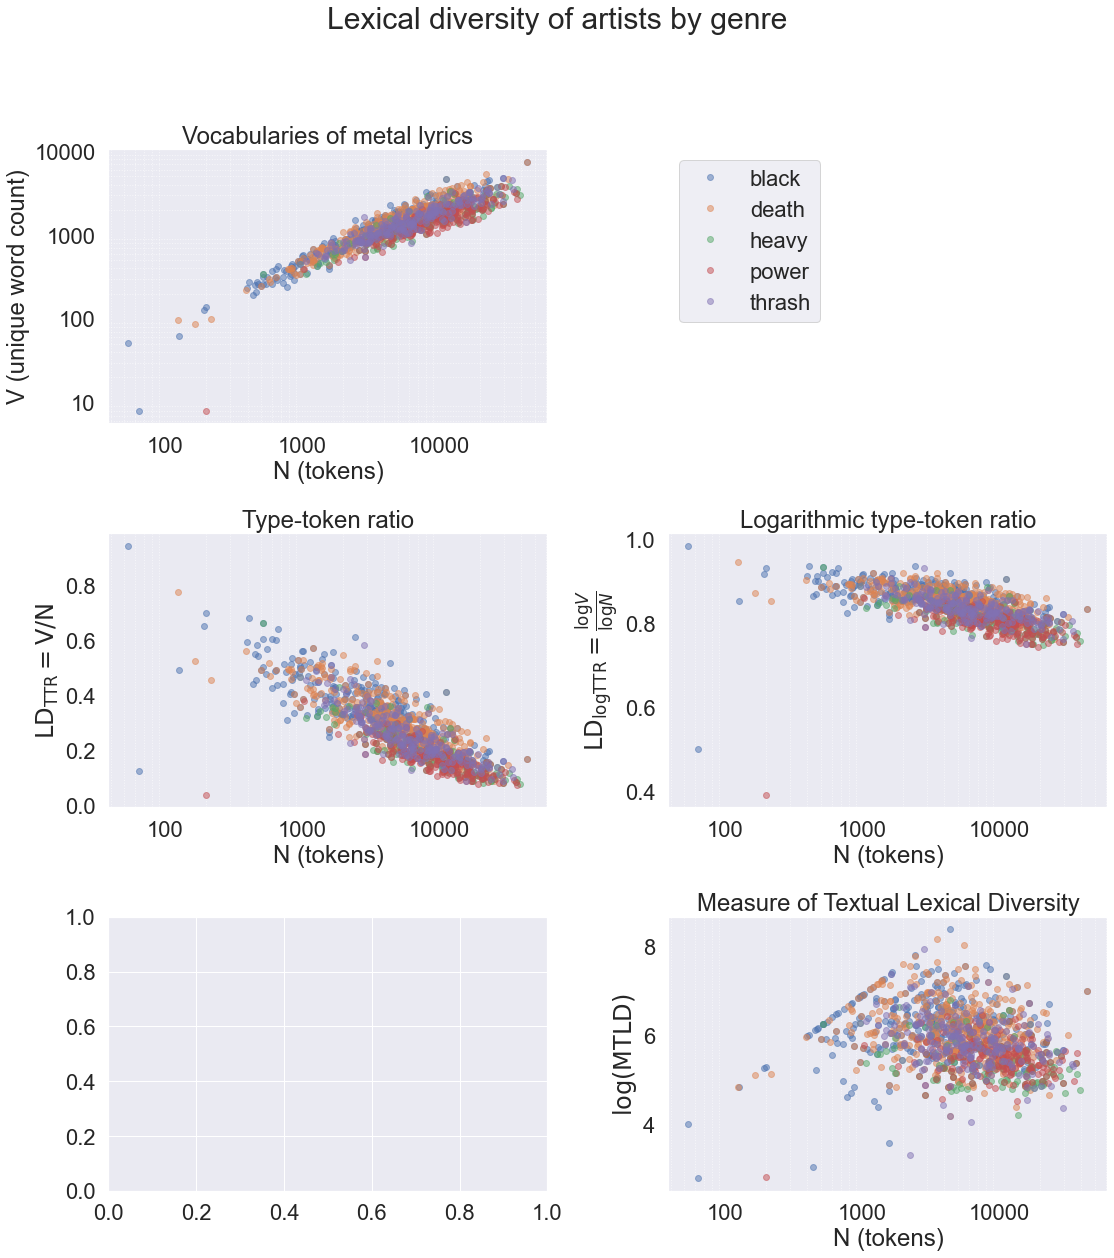

In [23]:
genres = df_bands.columns[:list(df_bands.columns).index('lyrics')]

def lexical_diversity_scatterplot(col, ax):
    for genre in genres:
        subset = df_bands[df_bands[genre] > 0]
        ax.plot(subset['N'], subset[col], 'o', markeredgewidth=1, alpha=0.5, label=genre)
    ax.set_xlabel("N (tokens)")
    ax.grid(axis='both', which='major')
    ax.grid(axis='both', which='minor', ls=':', alpha=0.6)
    return

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("Lexical diversity of artists by genre", fontsize=30)
axes = axes.flatten()

ax = axes[0]
lexical_diversity_scatterplot('V', ax)
ax.set_xscale('log')
ax.set_yscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Vocabularies of metal lyrics")
ax.set_ylabel("V (unique word count)")

ax = axes[1]
ax.axis('off')
for genre in genres:
    ax.plot([], [], 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.legend(frameon=True, loc='upper left')

ax = axes[2]
lexical_diversity_scatterplot('TTR', ax)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Type-token ratio")
ax.set_ylabel("$\mathrm{LD_{TTR} = V/N}$")

ax = axes[3]
lexical_diversity_scatterplot('logTTR', ax)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Logarithmic type-token ratio")
ax.set_ylabel(r"$\mathrm{LD_{logTTR}} = \frac{\log V}{\log N}$")

ax = axes[4]

ax = axes[5]
lexical_diversity_scatterplot('logmtld', ax)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Measure of Textual Lexical Diversity")
ax.set_ylabel(r"$\log(\mathrm{MTLD})$")

fig.tight_layout(rect=[0, 0, 1, 0.95])

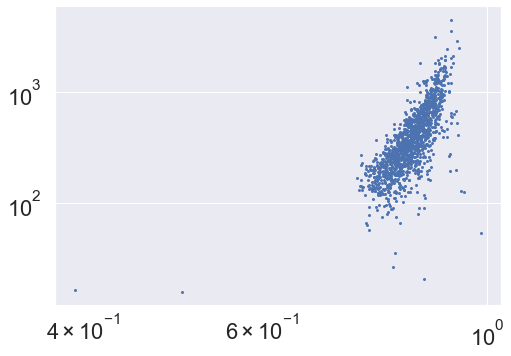

In [24]:
plt.plot(df_bands.logTTR, df_bands.mtld, '.')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Violin plots with expanded genres dataset

In [25]:
df_exp = pd.read_csv('songs-1pct.csv')
df_exp_bands = get_bands(df_exp)
df_exp_bands = get_lexical_diversity(df_exp_bands)

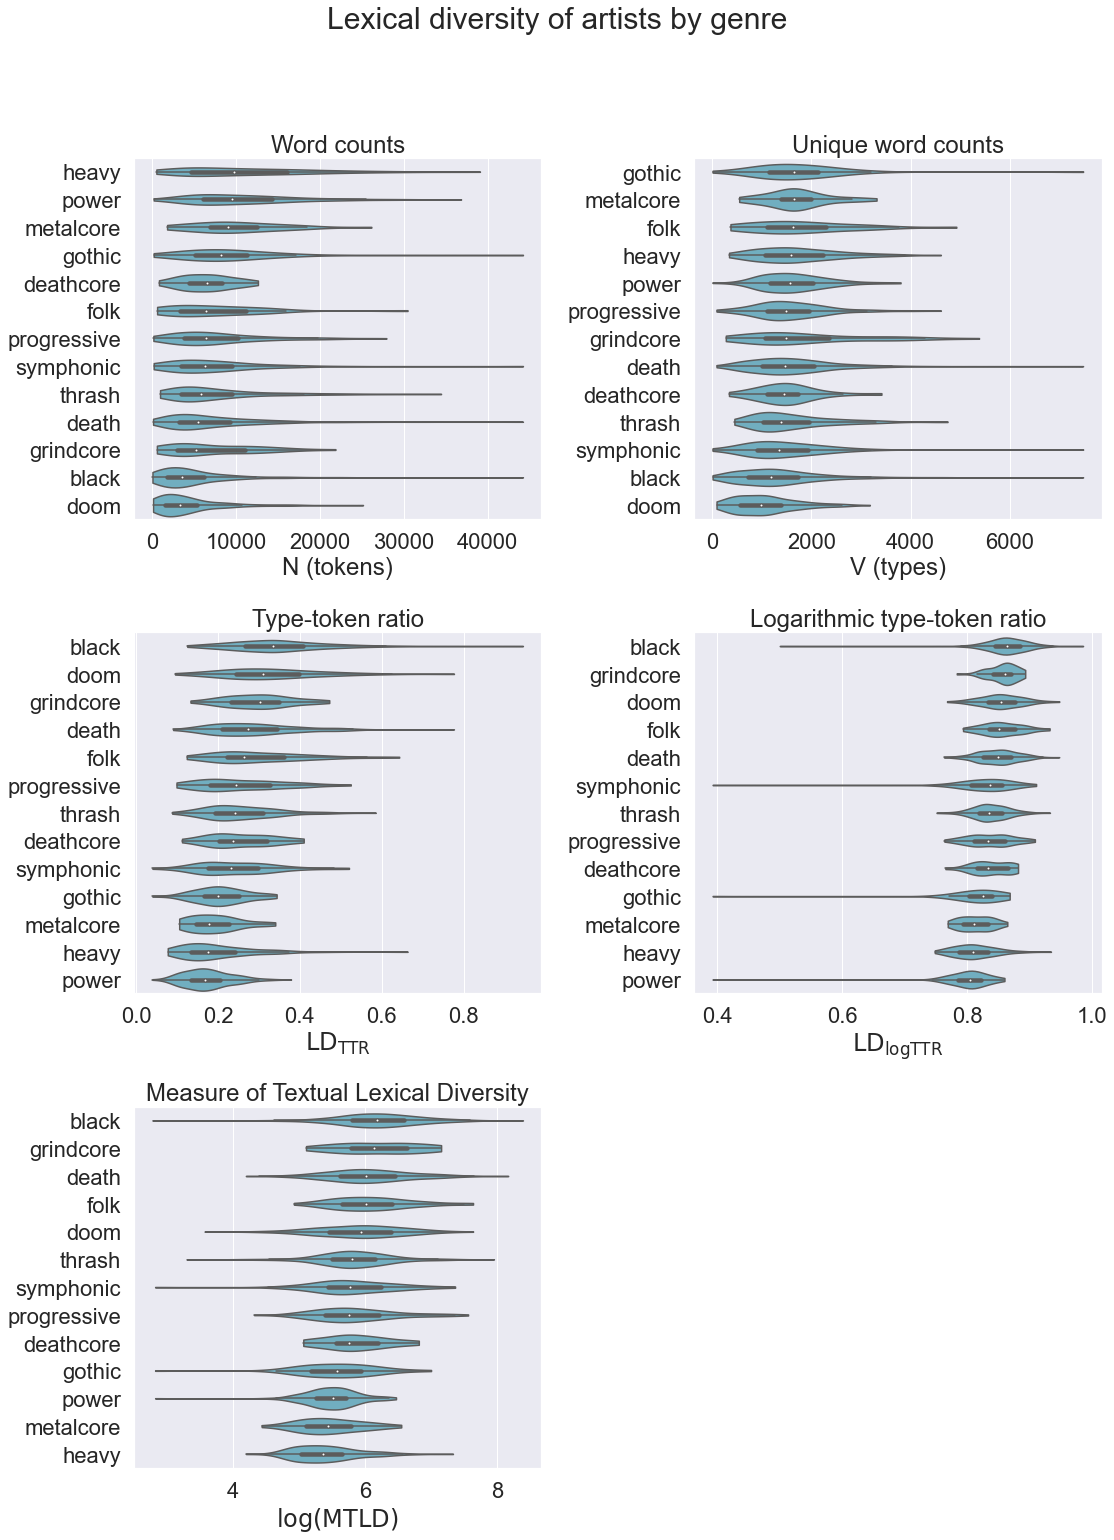

In [26]:
plot_violinplots(df_exp_bands, figsize=(16, 22))